# Note: Were are not worried about how model performs, The main aim is to build custom datasets for image in Pytorch

In [1]:
#import libraries

import os
import pandas as pd
from torch.utils.data import Dataset
from skimage import io
from torch.utils.data import DataLoader
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
#Defining class for loading the data

class CatVsDog(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations= pd.read_csv(csv_file)
        self.root_dir= root_dir
        self.transform= transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path= os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image= Image.open(img_path)
        y_label= torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image= self.transform(image)
            
        return (image, y_label)

In [3]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#Hyperparameters

in_channel=3
num_classes= 2
learning_rate=0.1
batch_size=32
num_epochs=10

In [5]:
#Loading directories

data= (r"C:\Users\shash\Downloads\Bepec\Datasets\archive\cats_dogs.csv")
root_dir=r"C:\Users\shash\Downloads\Bepec\Datasets\archive\cats_dogs_resized"

In [6]:
#Load Data

dataset= CatVsDog(csv_file=data, root_dir= root_dir,
                 transform=transforms.ToTensor(),
    )

In [7]:
data=pd.read_csv(data)

In [8]:
data.head()

,Animal,Label
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.2.jpg,0
3,cat.3.jpg,0
4,cat.4.jpg,0


In [9]:
#Function to display image data

def show_image(img, title=None):
    img= transforms.ToPILImage()(img)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.show()

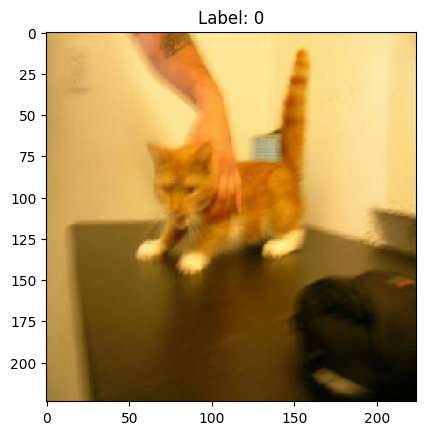

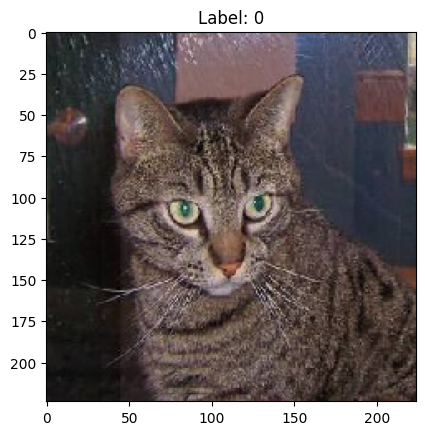

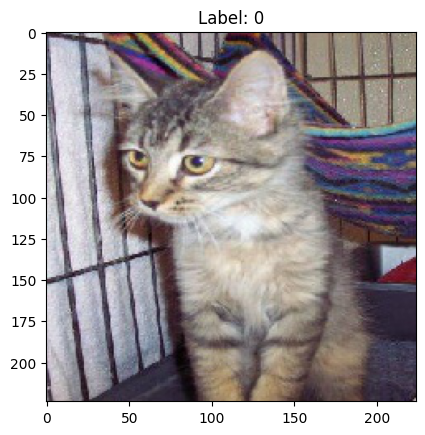

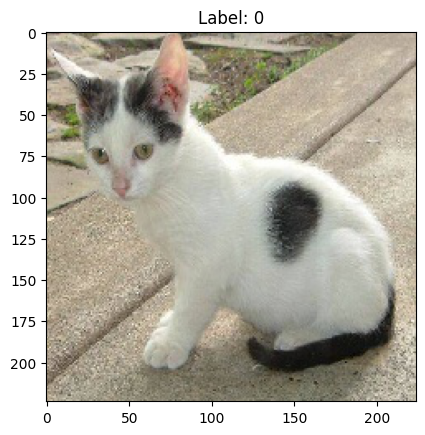

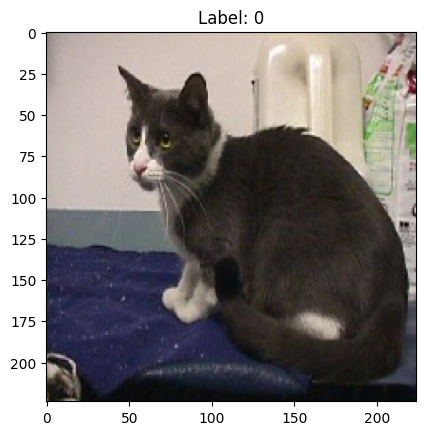

In [10]:
for i in range(5):
    image, label= dataset[i]
    show_image(image, title=f'Label: {label}')

In [11]:
train_set, test_set= torch.utils.data.random_split(dataset, [5, 5])
train_loader= DataLoader(dataset=train_set, batch_size=batch_size, shuffle= True)
test_loader= DataLoader(dataset= test_set, batch_size=batch_size, shuffle= True)

In [12]:
#Model

model=torchvision.models.googlenet(weights= "DEFAULT")

In [13]:
#Freeze all layers, change final linear layer with num_classes

for param in model.parameters():
    param.requires_grad= False

In [14]:
#final layer is not frozen

model.fc= nn.Linear(in_features= 1024, out_features= num_classes)
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [15]:
#Loss and optimizer

criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr= learning_rate, weight_decay=1e-5)

In [16]:
#Train Network

for epoch in range(num_epochs):
    losses= []
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data=data.to(device=device)
        targets= targets.to(device=device)
        
        scores= model(data)
        loss= criterion(scores, targets)
        
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    print(f" Cost at epoch{epoch} is {sum(losses)/len(losses)}")

 Cost at epoch0 is 0.6960606575012207
 Cost at epoch1 is 0.0
 Cost at epoch2 is 0.0
 Cost at epoch3 is 0.0
 Cost at epoch4 is 0.0
 Cost at epoch5 is 0.0
 Cost at epoch6 is 0.0
 Cost at epoch7 is 0.0
 Cost at epoch8 is 0.0
 Cost at epoch9 is 0.0


In [17]:
def check_accuracy(loader, model):
    num_correct= 0
    num_samples= 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x= x.to(device= device)
            y= y.to(device= device)
            
            scores= model(x)
            _, predictions= scores.max(1)
            num_correct +=(predictions==y).sum()
            num_samples +=predictions.size(0)
        
        print(f"Got {num_correct}/{num_samples} with accuracy{float(num_correct)/float(num_samples)*100:.2f}")
        
    model.train()    

In [18]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

Checking accuracy on Training Set
Got 5/5 with accuracy100.00
Checking accuracy on Test Set
Got 3/5 with accuracy60.00
